# Make model input data

In [82]:
import pandas as pd
import numpy as np

from pyproj import Transformer

from shapely.geometry import Point, mapping
from shapely.geometry import box as Box
from shapely.geometry import shape as Shape
from shapely.ops import transform as Shapely_transform
from geovoronoi import voronoi_regions_from_coords

from scipy.spatial import KDTree
import folium
import json

from matplotlib.path import Path
import matplotlib.cm as cm
import matplotlib.colors as colrs
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
import tensorflow as tf

import mapply

In [30]:
mapply.init(
    n_workers=10,
    chunk_size=1,
    progressbar=True
)

def get_map(location=[46.2276, 2.2137], zoom_start=5):
    return folium.Map(location=location, zoom_control=True, zoom_start=zoom_start, 
                    tiles=f'https://api.mapbox.com/styles/v1/landys/cl9ox03vd002t14vqsj0xj8dd/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1IjoibGFuZHlzIiwiYSI6ImNraHFjeXA1NzA1ZzkycW11cjl3dnpyMnAifQ.7mSkfJjaSfJXoGBxa_rg1g', attr='Mapbox')


## Load data

In [120]:
france_file = f'data/france.geojson'

fd = open(france_file, 'r')
geojson_content = json.load(fd)
fd.close()

france_mainland = Shape(geojson_content['features'][0]['geometry'])
france_mainland = france_mainland.buffer(0)
# Changing to lat, lon
france_mainland = Shapely_transform(lambda x, y: (y, x), france_mainland)

In [90]:
m = get_map()

folium.Polygon(mapping(france_mainland)['coordinates'][0],
    color='lightblue',
    fill_color='lightblue',
    opacity = 1,
    fill_opacity = .01,
    tooltip='France mainland'
    ).add_to(m)

m

### Load BS deployment data

In [25]:
df_antennas = pd.read_csv('data/2022_T3_sites_Metropole.csv')
df_antennas.head(2)

,code_op,nom_op,num_site,id_site_partage,id_station_anfr,x,y,latitude,longitude,nom_reg,...,site_ZB,site_DCC,site_strategique,site_capa_240mbps,date_ouverturecommerciale_5g,site_5g_700_m_hz,site_5g_800_m_hz,site_5g_1800_m_hz,site_5g_2100_m_hz,site_5g_3500_m_hz
0,20801,Orange,00000001A1,NaN,0802290015,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,...,0,0,0,0,NaN,0,0,0,0,0
1,20801,Orange,00000001B1,NaN,0642290151,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,...,0,0,0,1,2020-12-14,0,0,0,1,0


In [34]:
# select one operator
operator = 'Orange'
df_antennas_op = df_antennas[df_antennas['nom_op'] == operator]

# select sites with 4G antennas
df_antennas_op_4G = df_antennas_op[df_antennas_op['site_4g'] == 1].copy()

# make id column
df_antennas_op_4G['antenna_id'] = df_antennas_op_4G.apply(lambda row: f"{row['code_op']}_{row['num_site']}_{row['id_station_anfr']}", axis=1)

# select only the columns we need
# x, y are in Lambert93!
df_antennas_op_4G = df_antennas_op_4G[['antenna_id', 'latitude', 'longitude']]

print(f'The number of 4G antennas for {operator}: {df_antennas_op_4G.shape[0]}')
df_antennas_op_4G.head(2)

The number of 4G antennas for Orange: 28600


,antenna_id,latitude,longitude
0,20801_00000001A1_0802290015,49.97028,2.81944
1,20801_00000001B1_0642290151,43.28861,-0.41389


### Make sites - aggregate by location

In [35]:
df_sites = df_antennas_op_4G.groupby(['latitude', 'longitude'], as_index=False).agg({'antenna_id': lambda x: list(x)})
df_sites.rename(columns={'antenna_id': 'antenna_ids'}, inplace=True)
print(f'The number of 4G sites for {operator}: {df_sites.shape[0]}')

df_sites.head(2)

The number of 4G sites for Orange: 28588


,latitude,longitude,antenna_ids
0,41.36445,9.26527,[20801_00006971V1_02A2290120]
1,41.37444,9.17889,[20801_00010120V1_02A2290147]


### Spatial filter - BSs inside France 

In [36]:
df_sites['inside'] = df_sites.mapply(lambda row: france_mainland.contains(Point(row['latitude'], row['longitude'])), axis=1)

print(f'Number of BS outside France mainland: {df_sites[~df_sites["inside"]].shape[0]} 📡🚫🗺️')
print(f'Keeping only BS inside France mainland: {df_sites[df_sites["inside"]].shape[0]} 📡🗺️')

df_sites = df_sites[df_sites['inside']].copy()
df_sites.drop(columns=['inside'], inplace=True)

df_sites.reset_index(drop=True, inplace=True)

df_sites = df_sites[['latitude', 'longitude', 'antenna_ids']]
df_sites.head(2)

  0%|          | 0/392 [00:00<?, ?it/s]

Number of BS outside France mainland: 399 📡🚫🗺️
Keeping only BS inside France mainland: 28189 📡🗺️


,latitude,longitude,antenna_ids
0,42.35360,2.61295,[20801_00082012K1_0662290324]
1,42.36365,2.65091,[20801_00082061K2_0342290655]


### Plot BS sites

In [40]:
m = get_map()

for site in df_sites.sample(1000, random_state=42).to_dict('records'):
    lat, lon = site['latitude'], site['longitude']
    antennas_ids = site['antenna_ids']
    folium.CircleMarker(
        location=[lat, lon], 
        radius=1, 
        color='red',
        tooltip=f'Antennas: {antennas_ids}'
    ).add_to(m)
    
m

## Estimate coverage

In [124]:
sites = zip(df_sites['latitude'], df_sites['longitude'])
sites = np.array(list(sites))

lambert93 = 'epsg:2154' # current version & updated
wgs = 'epsg:4326'
transform_wgs_to_lambert93 = Transformer.from_crs(wgs, lambert93).transform

france_mainland_meter = Shapely_transform(transform_wgs_to_lambert93, france_mainland)

lats, lons = list(zip(*sites))
xs, ys = transform_wgs_to_lambert93(lats, lons)
sites_meter = list(zip(xs, ys))
kdtree = KDTree(sites_meter)

spatial_resolution = 100 # meters
number_cells = 600 # number of cells per site
neighbors_number = 5

### Voronoi

In [125]:
region_polys, region_pts = voronoi_regions_from_coords(sites, france_mainland)

# Check that the Voronoi polygons are valid
if len(sites) != len(region_pts):
    # show a sample of the points that were assigned to more than one polygon
    print(list(filter(lambda k_v: len(k_v[1]) > 1, region_pts.items()))[0:10])
    raise Exception('Number of sites and assignments do not match 😨')
else:
    print(f'Number of sites and assignments match 🤩')

voronoi_cells = [None for i in range(len(sites))]

for voronoi_index, pts_index,  in region_pts.items():
    pts_index = pts_index[0] # only one point per polygon
    voronoi_cells[pts_index] = region_polys[voronoi_index]

for index, voronoi_cell in enumerate(voronoi_cells):
    if voronoi_cell.type == 'MultiPolygon':
        for polygon in voronoi_cell:
            if Point(lat, lon).within(polygon):
                break
        voronoi_cells[index] = polygon

Number of sites and assignments match 🤩


### Define the area of interest

In [126]:
def get_area_of_interest(site_index):
    x, y = sites_meter[site_index]
    left_x = (x - (number_cells//2)*spatial_resolution)//spatial_resolution * spatial_resolution
    bottom_y = (y - (number_cells//2)*spatial_resolution)//spatial_resolution * spatial_resolution

    return left_x, bottom_y

### Compute Mask

In [127]:
def discrete_shape(shape_meter, left_x, bottom_y):
    # matrix dims
    matrix = np.zeros((number_cells, number_cells))

    # polygon discrete
    xs, ys = shape_meter.exterior.xy
    xs = np.array(xs)
    ys = np.array(ys)

    xs_discrete_matrix = (xs - left_x)//spatial_resolution
    ys_discrete_matrix = (ys - bottom_y)//spatial_resolution

    x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0])) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((y, x)).T 

    p = Path(list(zip(ys_discrete_matrix, xs_discrete_matrix))) # make a polygon
    grid = p.contains_points(points)
    city_mask = grid.reshape(matrix.shape)
    
    # from True, False to 0,1
    city_mask = 1*np.array(city_mask)

    return city_mask

In [128]:
def compute_mask(left_x, bottom_y):

    matrix_shape = Box(left_x, bottom_y, left_x+number_cells*spatial_resolution, bottom_y+number_cells*spatial_resolution)
    intersection_shape = matrix_shape.intersection(france_mainland_meter)
    matrix_mask = discrete_shape(intersection_shape, left_x, bottom_y)
    
    return matrix_mask

### Compute Distance matrix

In [129]:
def compute_distance_matrix(site_index, mask):

    bs_coord_x, bs_coord_y = sites_meter[site_index]
    bs_coord = np.array([bs_coord_x, bs_coord_y])

    left_x, bottom_y = get_area_of_interest(site_index)

    distance_matrix = np.zeros((4, mask.shape[0], mask.shape[1]))

    n_row = mask.shape[0]
    ys = [bottom_y + i * 100 for i in range(n_row)]
    xs = [left_x + i * 100 for i in range(n_row)]


    for y_index, y in enumerate(ys):
        for x_index, x in enumerate(xs):

            l = np.array([x, y])

            bs_distance_to_l = np.sqrt(((l - bs_coord)**2).sum())
            # avoid having zero values (sea is zero)
            bs_distance_to_l += 1

            closer_neighbords_distances_to_l, _ = kdtree.query(l, neighbors_number)
            closer_neighbords_distances_to_l = np.array(closer_neighbords_distances_to_l)
            # avoid having zero values (sea is zero)
            closer_neighbords_distances_to_l += 1

            mean_closer_neighbords_distances_to_l = np.mean(closer_neighbords_distances_to_l)
            
            values = [bs_distance_to_l] + list(closer_neighbords_distances_to_l[0:2]) + [mean_closer_neighbords_distances_to_l]
            values = np.array(values)
            
            distance_matrix[:, y_index, x_index] = values

    # distance_matrix_0 is distance to bs without taking into account the mask
    distance_matrix_0 = distance_matrix[0]
    distance_matrix = distance_matrix[1:] * mask
    
    # Exp transform
    distance_matrix = 1 - np.exp(-distance_matrix/(distance_matrix_0))

    # changes of dims
    distance_matrix_ = np.zeros((distance_matrix.shape[1], distance_matrix.shape[2], distance_matrix.shape[0]))
    for i in range(distance_matrix.shape[0]):
        distance_matrix_[:, :, i] = distance_matrix[i]
    distance_matrix = distance_matrix_

    return distance_matrix

### Load model

In [130]:
simplifier_model  = load_model('Simplifier_SDUnet_ks2_015/',  custom_objects={'tf': tf})

In [131]:
def predict(distance_matrix, mask):
    model_input = np.array([distance_matrix])
    prediction = simplifier_model.predict(model_input)
    prediction = prediction[0]
    prediction = np.squeeze(prediction)

    prediction[prediction <= 0] = 1e-9
    prediction = 10**(-1 / prediction )
    prediction *= mask
    prediction /= prediction.sum()

    return prediction

In [135]:
def get_all(site_index):
    site = sites[site_index]
    left_x, bottom_y = get_area_of_interest(site_index)
    mask = compute_mask(left_x, bottom_y)
    distance_matrix = compute_distance_matrix(site_index, mask)
    prediction = predict(distance_matrix, mask)
    voronoi_cell = voronoi_cells[site_index]
    voronoi_cell_meter = Shapely_transform(transform_wgs_to_lambert93, voronoi_cell)
    voronoi_cell_matrix = discrete_shape(voronoi_cell_meter, left_x, bottom_y)

    return distance_matrix, prediction, voronoi_cell_matrix, mask

## Example

In [132]:
cmap_distance = cm.get_cmap('RdYlGn_r').copy()
cmap_distance.set_under('white')
norm_distance = colrs.Normalize(vmin=1e-4, vmax=1)

cmap_prob = cm.get_cmap('jet').copy()
cmap_prob.set_under('w', 0)
norm_prob = colrs.LogNorm(vmin=1e-9, vmax=5e-2)

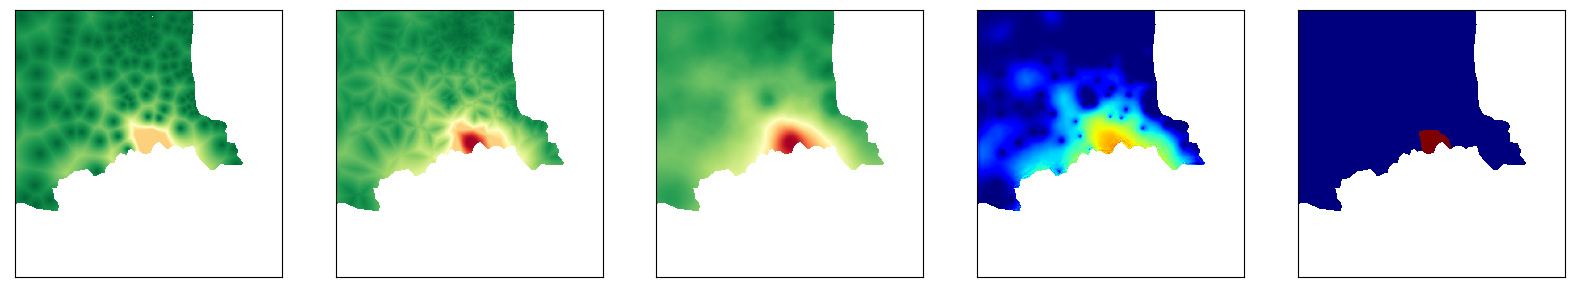

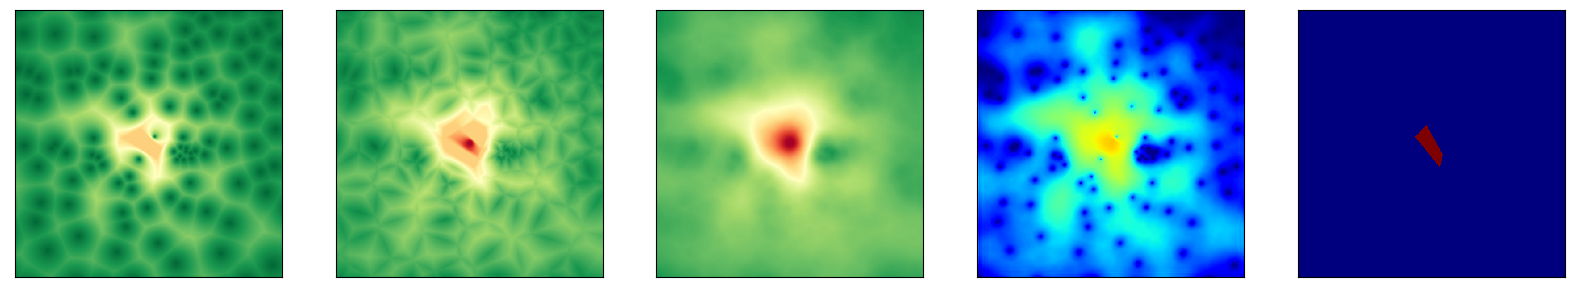

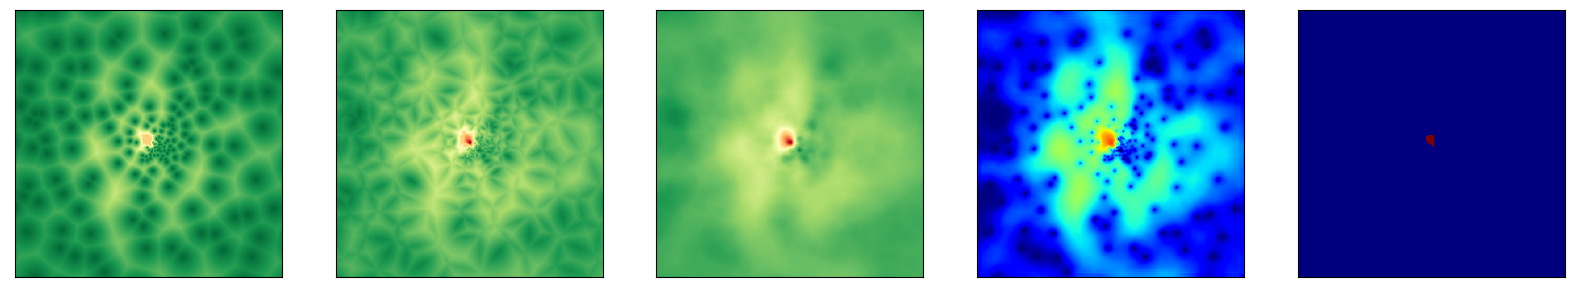

In [136]:
site_indexs = [18, 6783, 10101]

for site_index in site_indexs:

    distance_matrix, prediction, voronoi_cell_matrix, mask = get_all(site_index)
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for matrix_channel_index in range(distance_matrix.shape[-1]):
        ax = axs[matrix_channel_index]
        matrix_channel = distance_matrix[:, :, matrix_channel_index]
        
        ax.imshow(matrix_channel, cmap=cmap_distance, norm=norm_distance, origin='lower', interpolation='nearest')

        ax.set_xticks([])
        ax.set_yticks([])
 
    ax = axs[-2]
    ax.imshow(prediction+mask/1e9, cmap=cmap_prob, norm=norm_prob, origin='lower', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axs[-1]
    ax.imshow(voronoi_cell_matrix+mask/1e9, cmap=cmap_prob, norm=norm_prob, origin='lower', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()